In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import os
import random

In [2]:
color_dict = {0 : "red",
              1 : "orange",
              2 : "yellow",
              3 : "green",
              4 : "blue",
              5 : "purple",
              6 : "black"}


In [3]:
CPU_FREQ_COL = "CPU Frequencies"
GPU_FREQ_COL = "GPU Frequencies"
MEM_FREQ_COL = "Mem Frequencies"
INIT_TIME_COL = "Initialization Time"
ALLOC_TIME_COL = "Allocation Time"
CP_HTD_COL = "Copy To Device Time"
KERNEL_TIME_COL = "Kernel Time"
CP_DTH_COL = "Copy Back and Merge Time"
DALLOC_TIME_COL = "Deallocation Time"
REAL_TIME_COL = "Real Time"
USR_TIME_COL = "User Time"
SYS_TIME_COL = "System Time"
TOT_DATA_TRANSFER_LATENCY_COL = "Total Data Transfer Latency"
TOT_LATENCY_COL = "Total Latency"
TRANS_PERCENT_COL = "Transfer Percentage"
KERNEL_STD_COL = "Kernel STD"
TRANSFER_STD_COL = "Transfer STD"
KERNEL_SCORE_COL = "Kernel Score"
TRANSFER_SCORE_COL = "Transfer Score"
TOT_SCORE = "Total Score"
IDLE_POWER = "IdlePower"
ACTIVE_POWER = "ActivePower"

In [4]:
# For dealing with overlapping points
# https://stackoverflow.com/a/21276920

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, **kwargs):
    return ax.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

In [5]:
# Paths to files containing information from running HSTI and SSSP for many combinations of frequenciies
SSSP_DATA_PATH = "./combined_perf_pow.csv"
HSTI_DATA_PATH = "./hsti_combined.csv"

# Load the data frames in question
sssp_df = pd.read_csv(SSSP_DATA_PATH)
hsti_df = pd.read_csv(HSTI_DATA_PATH)

# Remove the index columns
sssp_df = sssp_df.drop(sssp_df.columns[0], axis = 1)
hsti_df = hsti_df.drop(hsti_df.columns[0:2], axis = 1)

In [6]:
sssp_df


,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time,Starttime,Endtime,ActivePower,IdlePower
0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,46363.0,19438.0,10767.0,405.0,46822.0,4.362,2.189
1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,40930.0,19075.0,10068.0,47290.0,88265.0,4.483,2.190
2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,36717.0,18457.0,9720.0,88666.0,125422.0,4.477,2.205
3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,33387.0,17890.0,9513.0,125765.0,159189.0,4.659,2.227
4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,31822.0,17584.0,9332.0,159512.0,191367.0,5.081,2.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,1085.032,7.747,767.195,4311.713,413.710,15.547,12918.0,3396.0,2039.0,18450087.0,18463031.0,5.920,3.404
1060,2000000.0,177000000.0,543000000.0,1004.038,6.759,681.166,4265.681,364.558,13.475,12427.0,2933.0,1915.0,18463269.0,18475719.0,6.223,3.511
1061,2000000.0,177000000.0,633000000.0,963.624,6.234,628.559,4132.461,338.542,12.868,11882.0,2750.0,1782.0,18475937.0,18487841.0,6.224,3.571
1062,2000000.0,177000000.0,728000000.0,980.685,5.847,609.559,4192.206,325.632,12.183,11979.0,2805.0,1685.0,18488051.0,18500051.0,5.721,3.593


In [7]:
# Create a "Total Score" column for both datasets, based on their runtime
# Lower runtime means better performance, and thus a higher "Total Score"
sssp_df[TOT_DATA_TRANSFER_LATENCY_COL] = sssp_df[CP_HTD_COL] + sssp_df[CP_DTH_COL]
sssp_df[TOT_LATENCY_COL] = sssp_df[TOT_DATA_TRANSFER_LATENCY_COL] + sssp_df[KERNEL_TIME_COL]
sssp_df[TOT_SCORE] = (sssp_df[TOT_LATENCY_COL].max() / sssp_df[TOT_LATENCY_COL])

hsti_df[TOT_DATA_TRANSFER_LATENCY_COL] = hsti_df[CP_HTD_COL] + hsti_df[CP_DTH_COL]
hsti_df[TOT_LATENCY_COL] = hsti_df[TOT_DATA_TRANSFER_LATENCY_COL] + hsti_df[KERNEL_TIME_COL]
hsti_df[TOT_SCORE] = (hsti_df[TOT_LATENCY_COL].max() / hsti_df[TOT_LATENCY_COL])

In [8]:
sssp_df.describe()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time,Starttime,Endtime,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score
count,1.064000e+03,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,1.100000e+06,4.051429e+08,4.735000e+08,2400.545090,13.391821,1355.155238,4395.308882,814.204289,28.999721,17080.421053,6572.244361,3555.377820,1.066462e+07,1.068173e+07,4.718928,2.940004,2169.359526,6564.668408,3.033404
std,5.479801e+05,1.400908e+08,2.315132e+08,1659.453104,7.760130,783.266763,2046.182332,485.018225,17.083647,7703.404622,3893.473841,1978.860838,4.990023e+06,4.985089e+06,0.950786,0.585979,1266.232018,2847.424253,1.211825
min,2.000000e+05,1.770000e+08,1.650000e+08,911.597000,5.613000,576.704000,1866.898000,314.561000,11.570000,7206.000000,2576.000000,1513.000000,4.050000e+02,4.682200e+04,2.862000,2.071000,891.265000,2795.727000,1.000000
25%,6.000000e+05,2.660000e+08,2.577500e+08,1330.899250,7.979000,848.776250,2649.876250,458.303750,17.001000,10891.500000,3919.500000,2179.000000,6.780502e+06,6.801124e+06,3.985500,2.465750,1311.779250,4222.268500,2.009212
50%,1.100000e+06,4.200000e+08,4.780000e+08,1789.700500,11.557000,1134.841500,3782.146000,668.646000,24.125500,14909.500000,5430.000000,3007.500000,1.113827e+07,1.114998e+07,4.645000,2.827000,1806.117500,5929.292000,2.822486
75%,1.600000e+06,5.430000e+08,6.567500e+08,2745.767250,16.100000,1483.414750,6073.969750,975.887250,33.380000,21945.250000,7480.750000,3996.750000,1.494130e+07,1.494990e+07,5.389250,3.305250,2470.699750,8329.313000,3.963590
max,2.000000e+06,6.000000e+08,8.250000e+08,8294.003000,126.079000,4392.729000,9976.650000,2544.532000,95.691000,46430.000000,21625.000000,11505.000000,1.850024e+07,1.851207e+07,7.907000,4.852000,6937.261000,16735.341000,5.986043


In [9]:
# Normalize power and performance values in both datasets
sssp_df["Transformed " + TOT_SCORE] = sssp_df[TOT_SCORE].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
sssp_df["Transformed " + ACTIVE_POWER] = sssp_df[ACTIVE_POWER].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

hsti_df["Transformed " + TOT_SCORE] = hsti_df[TOT_SCORE].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
hsti_df["Transformed Power (W)"] = hsti_df["Power (W)"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [10]:
# Plot the distribution of the tuples of frequencies

def plot_pca(df):
    ''' This function takes the data (in a format similar to that in PowerDVFS.csv)
        does PCA with 2 components on the 3 frequency values, and plots the frequency
        tuples in a 2-dimensional space.
        If the argument "df" has a column for clusters (there can be at most 7 clusters)
        then points representing each frequency tuple will be colored according to which
        cluster they were assigned to (based on their component power consumptions
        and performance benchmark scores)
        The purpose of this is to visualize our clustering.
    '''

    scaled_freq_df = StandardScaler().fit_transform(df[[CPU_FREQ_COL, GPU_FREQ_COL, MEM_FREQ_COL]])
    pca = PCA(n_components = 2)
    pca.fit(df[[CPU_FREQ_COL, GPU_FREQ_COL, MEM_FREQ_COL]])
    pca_df = pd.DataFrame(data = pca.transform(df[[CPU_FREQ_COL, GPU_FREQ_COL, MEM_FREQ_COL]]), columns = ["PC1", "PC2"])

    fig, ax = plt.subplots()

    # jitter() adds some jitter so we can see different points that are close
    # together distinctly.
    if "cluster" in df.columns:
        pca_df["cluster"] = df["cluster"]
        jitter(ax, pca_df["PC1"], pca_df["PC2"], c = pca_df["cluster"].map(color_dict)) 
    else:
        jitter(ax, pca_df["PC1"], pca_df["PC2"]) 

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Visualizing Frequency Tuples After PCA")

    plt.show()

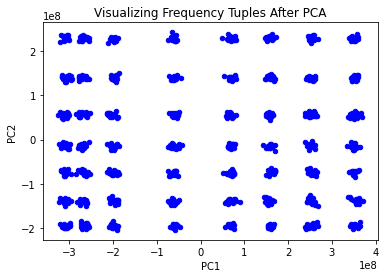

In [11]:
plot_pca(sssp_df)

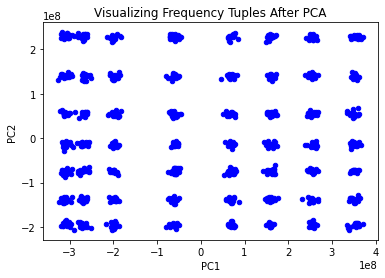

In [12]:
plot_pca(hsti_df)

In [13]:
# Make EDP column with Nu = 2 (Power and performance are equally important) for both datasets
sssp_df["EDP_2"] = sssp_df["Transformed ActivePower"] * pow(sssp_df["Transformed Total Score"], 2)
hsti_df["EDP_2"] = hsti_df["Transformed Power (W)"] * pow(hsti_df["Transformed Total Score"], 2)

In [14]:
hsti_df.describe()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,...,System Time,Starttime,Endtime,Power (W),Total Data Transfer Latency,Total Latency,Total Score,Transformed Total Score,Transformed Power (W),EDP_2
count,1.064000e+03,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,...,1064.000000,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,1.100000e+06,4.051429e+08,4.735000e+08,7.629125,839.682682,21.275621,7.363705,0.547635,26.754936,1818.474624,...,249.964286,1.817509e+06,1.819428e+06,5.027313,21.823257,29.186962,3.118838,0.459770,0.329664,0.103081
std,5.479801e+05,1.400908e+08,2.315132e+08,3.532733,478.278132,9.138815,4.335313,0.313264,15.159968,1004.542819,...,125.667297,8.481877e+05,8.473614e+05,1.606894,9.431352,13.302380,1.121115,0.243272,0.193171,0.126548
min,2.000000e+05,1.770000e+08,1.650000e+08,1.857000,338.002000,9.669000,3.001000,0.206000,11.790000,774.000000,...,82.000000,1.496000e+03,7.146000e+03,2.285000,9.963000,13.829640,1.000000,0.000000,0.000000,0.000000
25%,6.000000e+05,2.660000e+08,2.577500e+08,4.912750,491.591500,13.715750,4.745290,0.326000,16.012250,1185.000000,...,161.000000,1.159294e+06,1.161548e+06,3.782825,14.067750,19.090055,2.128114,0.244791,0.180060,0.014595
50%,1.100000e+06,4.200000e+08,4.780000e+08,6.703000,705.196000,18.850500,5.912790,0.465000,22.096500,1511.000000,...,217.000000,1.894976e+06,1.896296e+06,4.827000,19.244500,25.123170,3.087322,0.452931,0.305584,0.052669
75%,1.600000e+06,5.430000e+08,6.567500e+08,9.007250,980.251750,26.354000,7.924665,0.637250,31.011750,2072.250000,...,293.000000,2.542608e+06,2.543660e+06,6.055675,26.970500,36.446945,4.063018,0.664648,0.453288,0.138324
max,2.000000e+06,6.000000e+08,8.250000e+08,20.917000,2634.781000,54.772000,22.912240,1.808000,83.806000,5550.000000,...,768.000000,3.153743e+06,3.154810e+06,10.603500,56.230000,77.563240,5.608479,1.000000,1.000000,0.837703


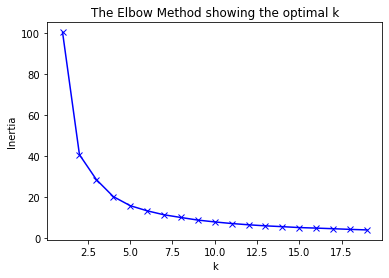

In [15]:
# Use elbow method to find best K for SSSP data
K = range(1, 20)
inertias = []

for k in K:
    sssp_output = sssp_df.copy()
    sssp_kmeans_model = KMeans(n_clusters = k, n_init = 10).fit(sssp_output[["Transformed ActivePower", "Transformed Total Score"]])
    sssp_output["cluster"] = sssp_kmeans_model.labels_.tolist()

    inertias.append(sssp_kmeans_model.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best

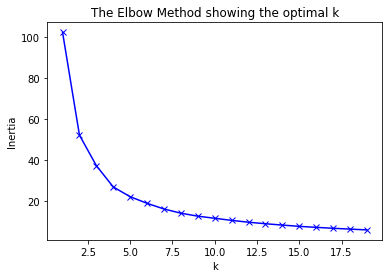

In [16]:
# Use elbow method to find best K for HSTI data
K = range(1, 20)
inertias = []

for k in K:
    hsti_output = hsti_df.copy()
    hsti_kmeans_model = KMeans(n_clusters = k, n_init = 10).fit(hsti_output[["Transformed Power (W)", "Transformed Total Score"]])
    hsti_output["cluster"] = hsti_kmeans_model.labels_.tolist()

    inertias.append(hsti_kmeans_model.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best

In [17]:
sssp_output = sssp_df.copy()
sssp_kmeans_model = KMeans(n_clusters = 4, n_init = 10).fit(sssp_output[["Transformed ActivePower", "Transformed Total Score"]])
sssp_output["cluster"] = sssp_kmeans_model.labels_.tolist()
sssp_output

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,...,Endtime,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,Transformed Total Score,Transformed ActivePower,EDP_2,cluster
0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,46363.0,...,46822.0,4.362,2.189,6313.179,16198.261,1.033157,0.006650,0.297324,0.000013,1
1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,40930.0,...,88265.0,4.483,2.190,6265.787,14110.555,1.186016,0.037307,0.321308,0.000447,1
2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,36717.0,...,125422.0,4.477,2.205,6134.266,12204.363,1.371259,0.074460,0.320119,0.001775,1
3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,33387.0,...,159189.0,4.659,2.227,6018.016,10714.089,1.561994,0.112713,0.356194,0.004525,3
4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,31822.0,...,191367.0,5.081,2.264,5954.440,10023.311,1.669642,0.134303,0.439841,0.007934,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,1085.032,7.747,767.195,4311.713,413.710,15.547,12918.0,...,18463031.0,5.920,3.404,1180.905,5492.618,3.046879,0.410522,0.606145,0.102152,3
1060,2000000.0,177000000.0,543000000.0,1004.038,6.759,681.166,4265.681,364.558,13.475,12427.0,...,18475719.0,6.223,3.511,1045.724,5311.405,3.150831,0.431370,0.666204,0.123968,3
1061,2000000.0,177000000.0,633000000.0,963.624,6.234,628.559,4132.461,338.542,12.868,11882.0,...,18487841.0,6.224,3.571,967.101,5099.562,3.281721,0.457622,0.666402,0.139556,3
1062,2000000.0,177000000.0,728000000.0,980.685,5.847,609.559,4192.206,325.632,12.183,11979.0,...,18500051.0,5.721,3.593,935.191,5127.397,3.263906,0.454049,0.566700,0.116831,0


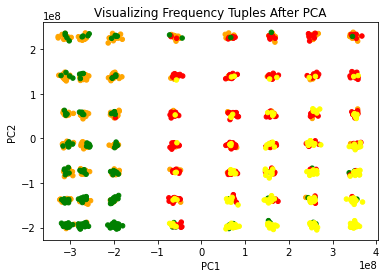

In [18]:
# Cluster based on total score and power usage
plot_pca(sssp_output)

In [19]:
hsti_output = hsti_df.copy()
hsti_kmeans_model = KMeans(n_clusters = 4, n_init = 10).fit(hsti_output[["Transformed Power (W)", "Transformed Total Score"]])
hsti_output["cluster"] = hsti_kmeans_model.labels_.tolist()
hsti_output

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,...,Starttime,Endtime,Power (W),Total Data Transfer Latency,Total Latency,Total Score,Transformed Total Score,Transformed Power (W),EDP_2,cluster
0,200000.0,600000000.0,165000000.0,20.457,2634.781,53.210,22.47716,1.560,80.916,5529.0,...,1496.0,7146.0,4.5634,54.770,77.24716,1.004092,0.000888,0.273896,2.159229e-07,0
1,200000.0,600000000.0,206000000.0,19.545,2484.033,49.423,22.07668,1.481,78.351,5252.0,...,8327.0,13696.0,4.7529,50.904,72.98068,1.062791,0.013625,0.296676,5.507670e-05,0
2,200000.0,600000000.0,275000000.0,18.794,2366.936,45.953,21.60904,1.444,74.648,5107.0,...,14825.0,20038.0,4.9956,47.397,69.00604,1.124007,0.026908,0.325852,2.359361e-04,0
3,200000.0,600000000.0,413000000.0,17.052,2237.572,43.747,21.22224,1.557,72.392,4950.0,...,21115.0,26170.0,5.1748,45.304,66.52624,1.165904,0.036000,0.347394,4.502189e-04,0
4,200000.0,600000000.0,543000000.0,16.750,2172.947,43.156,21.19776,1.535,70.167,4872.0,...,27221.0,32191.0,5.3581,44.691,65.88876,1.177185,0.038448,0.369430,5.460959e-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,4.782,461.612,14.830,6.99126,0.270,14.011,1189.0,...,3145223.0,3146509.0,7.8866,15.100,22.09126,3.511037,0.544873,0.673391,1.999209e-01,1
1060,2000000.0,177000000.0,543000000.0,4.346,403.638,12.795,6.86412,0.258,13.043,1085.0,...,3147451.0,3148629.0,8.0964,13.053,19.91712,3.894300,0.628038,0.698612,2.755546e-01,1
1061,2000000.0,177000000.0,633000000.0,4.230,375.686,12.001,6.82188,0.246,12.441,1083.0,...,3149541.0,3150715.0,8.1526,12.247,19.06888,4.067530,0.665627,0.705368,3.125201e-01,1
1062,2000000.0,177000000.0,728000000.0,4.158,358.324,11.304,6.73962,0.216,12.289,1108.0,...,3151614.0,3152815.0,8.2531,11.520,18.25962,4.247801,0.704745,0.717449,3.563320e-01,1


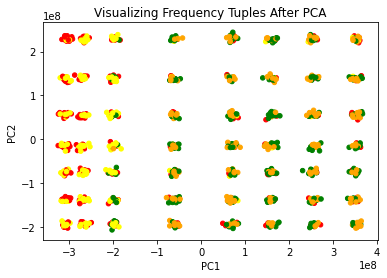

In [20]:
plot_pca(hsti_output)

In [21]:
# Tuples of frequencies are the same between two datasets
print(all(sssp_df[CPU_FREQ_COL] == hsti_df[CPU_FREQ_COL]))
print(all(sssp_df[GPU_FREQ_COL] == hsti_df[GPU_FREQ_COL]))
print(all(sssp_df[MEM_FREQ_COL] == hsti_df[MEM_FREQ_COL]))

True
True
True


In [22]:
print(all(sssp_output["cluster"] == hsti_output["cluster"]))

False


In [23]:
# Each combination of frequencies is only seen once in each dataset
# https://stackoverflow.com/a/35268906
print(sssp_df.groupby([CPU_FREQ_COL, GPU_FREQ_COL, MEM_FREQ_COL]).size().reset_index().rename(columns={0:'count'})["count"].max())
print(hsti_df.groupby([CPU_FREQ_COL, GPU_FREQ_COL, MEM_FREQ_COL]).size().reset_index().rename(columns={0:'count'})["count"].max())

1
1


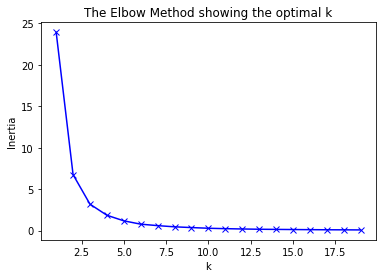

In [24]:
# Use elbow method to find best K for SSSP data
K = range(1, 20)
inertias = []

for k in K:
    sssp_output_edp = sssp_df.copy()
    sssp_kmeans_model_edp = KMeans(n_clusters = k, n_init = 10).fit(sssp_output_edp[["EDP_2"]])
    sssp_output_edp["cluster"] = sssp_kmeans_model_edp.labels_.tolist()

    inertias.append(sssp_kmeans_model_edp.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 3 seems best

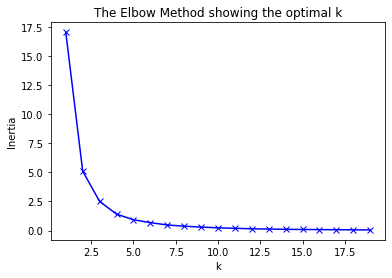

In [25]:
# Use elbow method to find best K for HSTI data
K = range(1, 20)
inertias = []

for k in K:
    hsti_output_edp = hsti_df.copy()
    hsti_kmeans_model_edp = KMeans(n_clusters = k, n_init = 10).fit(hsti_output_edp[["EDP_2"]])
    hsti_output_edp["cluster"] = hsti_kmeans_model_edp.labels_.tolist()

    inertias.append(hsti_kmeans_model_edp.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 3 seems best

In [26]:
sssp_output_edp = sssp_df.copy()
sssp_kmeans_model_edp = KMeans(n_clusters = 3, n_init = 10).fit(sssp_output_edp[["EDP_2"]])
sssp_output_edp["cluster"] = sssp_kmeans_model_edp.labels_.tolist()
sssp_output_edp

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,...,Endtime,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,Transformed Total Score,Transformed ActivePower,EDP_2,cluster
0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,46363.0,...,46822.0,4.362,2.189,6313.179,16198.261,1.033157,0.006650,0.297324,0.000013,0
1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,40930.0,...,88265.0,4.483,2.190,6265.787,14110.555,1.186016,0.037307,0.321308,0.000447,0
2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,36717.0,...,125422.0,4.477,2.205,6134.266,12204.363,1.371259,0.074460,0.320119,0.001775,0
3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,33387.0,...,159189.0,4.659,2.227,6018.016,10714.089,1.561994,0.112713,0.356194,0.004525,0
4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,31822.0,...,191367.0,5.081,2.264,5954.440,10023.311,1.669642,0.134303,0.439841,0.007934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,1085.032,7.747,767.195,4311.713,413.710,15.547,12918.0,...,18463031.0,5.920,3.404,1180.905,5492.618,3.046879,0.410522,0.606145,0.102152,0
1060,2000000.0,177000000.0,543000000.0,1004.038,6.759,681.166,4265.681,364.558,13.475,12427.0,...,18475719.0,6.223,3.511,1045.724,5311.405,3.150831,0.431370,0.666204,0.123968,2
1061,2000000.0,177000000.0,633000000.0,963.624,6.234,628.559,4132.461,338.542,12.868,11882.0,...,18487841.0,6.224,3.571,967.101,5099.562,3.281721,0.457622,0.666402,0.139556,2
1062,2000000.0,177000000.0,728000000.0,980.685,5.847,609.559,4192.206,325.632,12.183,11979.0,...,18500051.0,5.721,3.593,935.191,5127.397,3.263906,0.454049,0.566700,0.116831,0


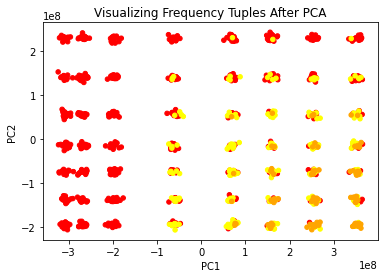

In [27]:
# Cluster based on EDP with nu = 2
plot_pca(sssp_output_edp)

In [28]:
hsti_output_edp = hsti_df.copy()
hsti_kmeans_model_edp = KMeans(n_clusters = 3, n_init = 10).fit(hsti_output_edp[["EDP_2"]])
hsti_output_edp["cluster"] = hsti_kmeans_model_edp.labels_.tolist()
hsti_output_edp

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,...,Starttime,Endtime,Power (W),Total Data Transfer Latency,Total Latency,Total Score,Transformed Total Score,Transformed Power (W),EDP_2,cluster
0,200000.0,600000000.0,165000000.0,20.457,2634.781,53.210,22.47716,1.560,80.916,5529.0,...,1496.0,7146.0,4.5634,54.770,77.24716,1.004092,0.000888,0.273896,2.159229e-07,0
1,200000.0,600000000.0,206000000.0,19.545,2484.033,49.423,22.07668,1.481,78.351,5252.0,...,8327.0,13696.0,4.7529,50.904,72.98068,1.062791,0.013625,0.296676,5.507670e-05,0
2,200000.0,600000000.0,275000000.0,18.794,2366.936,45.953,21.60904,1.444,74.648,5107.0,...,14825.0,20038.0,4.9956,47.397,69.00604,1.124007,0.026908,0.325852,2.359361e-04,0
3,200000.0,600000000.0,413000000.0,17.052,2237.572,43.747,21.22224,1.557,72.392,4950.0,...,21115.0,26170.0,5.1748,45.304,66.52624,1.165904,0.036000,0.347394,4.502189e-04,0
4,200000.0,600000000.0,543000000.0,16.750,2172.947,43.156,21.19776,1.535,70.167,4872.0,...,27221.0,32191.0,5.3581,44.691,65.88876,1.177185,0.038448,0.369430,5.460959e-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,4.782,461.612,14.830,6.99126,0.270,14.011,1189.0,...,3145223.0,3146509.0,7.8866,15.100,22.09126,3.511037,0.544873,0.673391,1.999209e-01,1
1060,2000000.0,177000000.0,543000000.0,4.346,403.638,12.795,6.86412,0.258,13.043,1085.0,...,3147451.0,3148629.0,8.0964,13.053,19.91712,3.894300,0.628038,0.698612,2.755546e-01,1
1061,2000000.0,177000000.0,633000000.0,4.230,375.686,12.001,6.82188,0.246,12.441,1083.0,...,3149541.0,3150715.0,8.1526,12.247,19.06888,4.067530,0.665627,0.705368,3.125201e-01,1
1062,2000000.0,177000000.0,728000000.0,4.158,358.324,11.304,6.73962,0.216,12.289,1108.0,...,3151614.0,3152815.0,8.2531,11.520,18.25962,4.247801,0.704745,0.717449,3.563320e-01,2


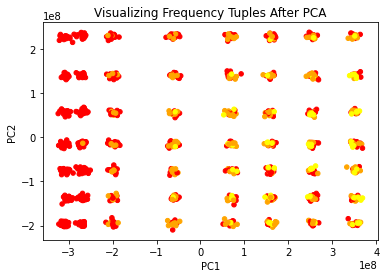

In [29]:
# Cluster based on EDP with nu = 2
plot_pca(hsti_output_edp)

In [30]:
print(all(sssp_output_edp["cluster"] == hsti_output_edp["cluster"]))
print(np.sum(sssp_output_edp["cluster"] == hsti_output_edp["cluster"]))

# Cluster x for SSSP and Cluster X for HSTI aren't necessarily the same, anyways

False
708


In [32]:
# See which pairs of frequency tuples are in the same cluster in both assigments of tuples to clusters
# Takes about 6-7 minutes (unusually long? Just 565516 O(1) operations? No math?)

# table_related_tuples[i][j] = 1 if and only if frequency tuples i and j are in
# the same cluster in both datasets and i < j
table_related_tuples_edp = np.zeros((sssp_output_edp.shape[0], sssp_output_edp.shape[0]))

visited = 0

for i in range(sssp_output_edp.shape[0]):
    for j in range(i + 1, hsti_output_edp.shape[0]):
        visited += 1
        if (sssp_output_edp.iloc[i]["cluster"] == sssp_output_edp.iloc[j]["cluster"]) and \
           (hsti_output_edp.iloc[i]["cluster"] == hsti_output_edp.iloc[j]["cluster"]):
               table_related_tuples_edp[i, j] = 1

In [33]:
# Visits the correct number of tuples (half the total number of non-identical pairs,
# as the pair (x, y) is the same as the pair (y, x))
print(visited)
print(1064 * 1063 * 0.5)

565516
565516.0


In [34]:
# Number of pairs of tuples that are in same cluster in both clusterings
# 1064 * 1063 * 0.5 * 0.33 = 186620.28 (expected to be in same cluster?)
# 221204.0 / (1064 * 1063 * 0.5) = 0.39115427326 (almost 40% coverage, fairly good according to Dipayan)
# Much higher?

table_related_tuples_edp.sum()

221738.0

In [35]:
np.sum(table_related_tuples_edp.sum(axis = 1) > 0) # out of 1064 tuples, ~1055 should be in a clique? # Seems stable, 1055 both times

1055

In [36]:
table_related_tuples_edp[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [37]:
np.sum(table_related_tuples_edp[0, :])

639.0

In [38]:
# Very fast
# Find all cliques
# This algorithm should work, because if Tuples A and B are in the same cluster for
# both SSSP and HSTI, and Tuples B and C are also in the same cluster both times,
# Then Tuples A and C will be in the same cluster both times

cliques = {}

for i in range(sssp_output_edp.shape[0]):
    in_preexisting_clique = False
    for key in cliques.keys():
        if i in cliques[key]:
            in_preexisting_clique = True
            break
    if not in_preexisting_clique:
        cliques[i] = {i}
        for j in range(i + 1, sssp_output_edp.shape[0]):
            if table_related_tuples_edp[i, j] == 1:
                cliques[i].add(j)

# for j in range(sssp_output_edp.shape[0]):
#     if table_related_tuples_edp[same_clique_as_tuple, j] == 1 or table_related_tuples_edp[j, same_clique_as_tuple] == 1:
#         # print("Tuple", j, "is in a clique with tuple", same_clique_as_tuple)
#         clique.append(j)

In [39]:
print(cliques.keys())

dict_keys([0, 174, 335, 341, 399, 455, 676, 741, 829])


In [40]:
print(cliques[174])

{516, 637, 647, 524, 525, 526, 404, 532, 533, 788, 284, 285, 286, 287, 413, 414, 542, 804, 293, 294, 295, 422, 939, 174, 175, 302, 303, 431, 311, 452, 453, 454, 582, 709, 971, 460, 461, 589, 591, 340, 597, 470, 599, 348, 349, 350, 479, 996, 229, 230, 231, 357, 358, 359, 998, 748, 877, 238, 239, 366, 367, 627, 629, 757, 247, 758, 507, 508, 509, 766}


In [41]:
sum = 0

for key in cliques.keys():
    sum += len(cliques[key])
    print("key =", key, "size of clique = ", len(cliques[key]))

# Every point covered (maybe previously, we had some rows with all 0s,
# but that was because they don't have symmetric link back to earlier-indexed tuple)???
# More cliques than clusters????
print(sum) 

key = 0 size of clique =  640
key = 174 size of clique =  70
key = 335 size of clique =  105
key = 341 size of clique =  121
key = 399 size of clique =  36
key = 455 size of clique =  14
key = 676 size of clique =  32
key = 741 size of clique =  43
key = 829 size of clique =  3
1064


In [42]:
sssp_output_edp.groupby("cluster")[["cluster", "EDP_2"]].agg({"EDP_2": ["min", "mean", "max"]})

EDP_2                                       
        cluster              EDP_2                    
            min mean max       min      mean       max
cluster                                               
0             0    0   0  0.000000  0.031986  0.121885
1             1    1   1  0.357521  0.493776  0.892765
2             2    2   2  0.123968  0.215858  0.350040

In [43]:
hsti_output_edp.groupby("cluster")[["cluster", "EDP_2"]].agg({"EDP_2": ["min", "mean", "max"]})

EDP_2                                       
        cluster              EDP_2                    
            min mean max       min      mean       max
cluster                                               
0             0    0   0  0.000000  0.034427  0.113067
1             1    1   1  0.113533  0.191315  0.317486
2             2    2   2  0.322698  0.443957  0.837703

In [46]:
# See which pairs of frequency tuples are in the same cluster in both assigments of tuples to clusters
# Takes about 5-6 minutes (unusually long? Just 565516 O(1) operations? No math?)

# table_related_tuples[i][j] = 1 if and only if frequency tuples i and j are in
# the same cluster in both datasets

# Symmetric relationships are considered this time!!!
table_related_tuples_edp = np.zeros((sssp_output_edp.shape[0], sssp_output_edp.shape[0]))

visited = 0

for i in range(sssp_output_edp.shape[0]):
    for j in range(hsti_output_edp.shape[0]):
        visited += 1
        if (sssp_output_edp.iloc[i]["cluster"] == sssp_output_edp.iloc[j]["cluster"]) and \
           (hsti_output_edp.iloc[i]["cluster"] == hsti_output_edp.iloc[j]["cluster"]) and \
           i != j:
               table_related_tuples_edp[i, j] = 1

In [47]:
np.sum(table_related_tuples_edp.sum(axis = 1) > 1) # out of 1064 tuples, ~1064 should be in a clique
# DIFFERENT FROM BEFORE!!!!!
# Still 1064???

1064

In [48]:
sssp_output_edp.iloc[0]["cluster"]

0.0

In [49]:
hsti_output_edp.iloc[0]["cluster"]

0.0

In [50]:
# Make a dataframe that tells you the EDPs (Nu = 2) and clusters (based on SSSP and HSTI) for each tuple
combined_df = sssp_output_edp.join(other = hsti_output_edp, \
                                   lsuffix = "_SSSP", \
                                   rsuffix = "_HSTI")
combined_df = combined_df[["CPU Frequencies_SSSP", \
                           "GPU Frequencies_SSSP", \
                           "Mem Frequencies_SSSP", \
                           "EDP_2_SSSP", \
                           "EDP_2_HSTI", \
                           "cluster_SSSP", \
                           "cluster_HSTI"]]

combined_df = combined_df.rename(columns = {"CPU Frequencies_SSSP": CPU_FREQ_COL, \
                                            "GPU Frequencies_SSSP": GPU_FREQ_COL, \
                                            "Mem Frequencies_SSSP": MEM_FREQ_COL})

combined_df

,CPU Frequencies,GPU Frequencies,Mem Frequencies,EDP_2_SSSP,EDP_2_HSTI,cluster_SSSP,cluster_HSTI
0,200000.0,600000000.0,165000000.0,0.000013,2.159229e-07,0,0
1,200000.0,600000000.0,206000000.0,0.000447,5.507670e-05,0,0
2,200000.0,600000000.0,275000000.0,0.001775,2.359361e-04,0,0
3,200000.0,600000000.0,413000000.0,0.004525,4.502189e-04,0,0
4,200000.0,600000000.0,543000000.0,0.007934,5.460959e-04,0,0
...,...,...,...,...,...,...,...
1059,2000000.0,177000000.0,413000000.0,0.102152,1.999209e-01,0,1
1060,2000000.0,177000000.0,543000000.0,0.123968,2.755546e-01,2,1
1061,2000000.0,177000000.0,633000000.0,0.139556,3.125201e-01,2,1
1062,2000000.0,177000000.0,728000000.0,0.116831,3.563320e-01,0,2


In [51]:
# Here, we get a dictionary containing dataframes containing all tuples in each
# clique of tuples that are in the same cluster each time 

# Key = index of one tuple in the clique. Value = dataframe containing all
# tuples in that clique
clique_dfs = {}

for key in cliques.keys():
    clique_dfs[key] = combined_df.iloc[list(cliques[key])]

In [52]:
clique_dfs.keys()

dict_keys([0, 174, 335, 341, 399, 455, 676, 741, 829])

In [53]:
curr_index = 0

print(clique_dfs[curr_index].shape)
print(clique_dfs[curr_index])

(640, 7)
      CPU Frequencies  GPU Frequencies  Mem Frequencies  EDP_2_SSSP  \
0            200000.0      600000000.0      165000000.0    0.000013   
1            200000.0      600000000.0      206000000.0    0.000447   
2            200000.0      600000000.0      275000000.0    0.001775   
3            200000.0      600000000.0      413000000.0    0.004525   
4            200000.0      600000000.0      543000000.0    0.007934   
...               ...              ...              ...         ...   
1041        2000000.0      350000000.0      206000000.0    0.030058   
1048        2000000.0      266000000.0      165000000.0    0.010070   
1049        2000000.0      266000000.0      206000000.0    0.034462   
1056        2000000.0      177000000.0      165000000.0    0.011218   
1057        2000000.0      177000000.0      206000000.0    0.033055   

        EDP_2_HSTI  cluster_SSSP  cluster_HSTI  
0     2.159229e-07             0             0  
1     5.507670e-05             0        